# Running the entire pipeline with all of the TF motifs

 - Retrieve all TF motifs from JASPAR identifies fro Homo sapiens. 
 - Create mutated sequences with AP1 at a fixed location (10th position) and the 2nd motif at a varying distance from AP1 (23 to 244 with a step increase of 20) for the 300bp background sequences. This is done for all the TF motifs retrieved from the JASPAR database
 - Obtain the predicted scores of these mutated sequences using the BlueSTARR model and calculate the logFC as Mutated_seq_score - Background_seq_score
 - Plot the mean logFC for each motif as a boxplot

In [3]:
%%writefile /hpc/home/rv103/revathy/BlueSTARR/test/scripts/retrieve_jaspar_motifs_v1.py
import requests
import csv
import time
import argparse

def get_motifs(base_url,params,page): 
    all_motifs = []
    while True:
        params['page'] = page
        response = requests.get(base_url, params=params)
        if response.status_code == 200:
            motif_info = response.json()
            motifs_data = motif_info.get('results')
            if not motifs_data:
                break
            print(f"Page {page} completed")
            all_motifs.extend(motifs_data)
            page += 1  # Move to the next page
        else:
            print(f"Error fetching motifs: {response.status_code}")
            break
    return all_motifs

def pwm_to_consensus(pwm):
    consensus = ""
    positions = range(len(pwm['A']))
    for i in positions:  
        max_val = -1
        max_base = ""
        for base in "ACGT":
            if pwm[base][i] > max_val:
                max_val = pwm[base][i]
                max_base = base
        consensus += max_base
    return consensus

def rev_comp(seq):
    complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}
    return "".join(complement[n] for n in reversed(seq))

def main(output_file):
    base_url = "https://jaspar.genereg.net/api/v1/matrix/"
    params = {'tax_id': 9606, 'page_size': 1000}
    page = 1
    processed_data = []

    all_motifs = get_motifs(base_url, params, page)

    for motif in all_motifs:
        motif_id = motif.get('matrix_id')
        motif_name = motif.get('name')
        
        pwm_url = f"https://jaspar.genereg.net/api/v1/matrix/{motif_id}/"
        pwm_response = requests.get(pwm_url)
        if pwm_response.status_code == 200:
            motif_details = pwm_response.json()
            print(f"Got motif details for {motif_id}")
            pwm = motif_details.get('pfm')  
            if pwm:
                consensus_sequence = pwm_to_consensus(pwm)
                processed_data.append([motif_id, motif_name, consensus_sequence])
            else:
                print(f"PWM missing for motif {motif_id}")
                processed_data.append([motif_id, motif_name, "N/A"])
        else:
            print(f"Error fetching PWM for motif {motif_id}: {pwm_response.status_code}")
            processed_data.append([motif_id, motif_name, "N/A"])


    df = pd.DataFrame(processed_data, columns=["MotifID", "TF", "motif_sequence"])

    # Step 2: Add suffixes to duplicate TF names and compute reverse complement
    df['TF_suffix'] = df.groupby('TF').cumcount() + 1
    df['TF'] = df.apply(lambda x: f"{x['TF']}_{x['TF_suffix']}" if x['TF_suffix'] > 1 else x['TF'], axis=1)
    df['reverse_sequence'] = df['motif_sequence'].apply(rev_comp)
    df[['TF', 'motif_sequence', 'reverse_sequence']].to_csv(output_file, sep='\t', index=False, header=False)
    print(f"Processed data saved to '{output_file}'.")

    
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="This script uses the JASPAR API to retrieve all motifs reported for Homo sapiens. The script converts the Position Weighted Matrix (PWM) scores into consensus sequence for each motif.")
    parser.add_argument("output_file", help='Path to the output .txt file')
    args = parser.parse_args()
    main(args.output_file)

Overwriting /hpc/home/rv103/revathy/BlueSTARR/test/scripts/retrieve_jaspar_motifs_v1.py


In [17]:
%%writefile /hpc/home/rv103/revathy/BlueSTARR/test/scripts/retrieve_jaspar_motifs_v1.q
#!/bin/sh
#
#SBATCH --get-user-env
#SBATCH -J jaspar_motifs
#SBATCH --mail-user=rv103@duke.edu
#SBATCH --mail-type=END,FAIL
#SBATCH --gres=gpu:1
#SBATCH -p majoroslab-gpu,scavenger-gpu
#SBATCH --nice=100
#SBATCH --mem=102400
#SBATCH --cpus-per-task=1
#SBATCH -o /hpc/home/rv103/revathy/BlueSTARR/test/logs/jaspar_motifs_v1.out
#SBATCH -e /hpc/home/rv103/revathy/BlueSTARR/test/logs/jaspar_motifs_v1.err
#
python /hpc/home/rv103/revathy/BlueSTARR/test/scripts/retrieve_jaspar_motifs_v1.py \
/hpc/home/rv103/revathy/BlueSTARR/test/data/K562/all_motifs/human_tf_pwm_consensus_sequences_v1.csv

Writing /hpc/home/rv103/revathy/BlueSTARR/test/scripts/retrieve_jaspar_motifs_v1.q


#### Modify the consensus sequence table to differentiate between different sequences of the same motif and add the rev comp for each sequence

In [1]:
%%writefile /hpc/home/rv103/revathy/BlueSTARR/test/scripts/consensus_sequence_data_wrangling.py
import pandas as pd
import argparse

def rev_comp(seq):
    complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}
    return "".join(complement[n] for n in reversed(seq))

def main(infile, outfile):
    table = pd.read_csv(infile, sep=',')
    table['TF_suffix'] = table.groupby('Transcription Factor').cumcount() + 1
    table['TF'] = table.apply(lambda x: f"{x['Transcription Factor']}_{x['TF_suffix']}" if x['TF_suffix'] > 1 else x['Transcription Factor'], axis=1)
    table['reverse_sequence'] = table['Consensus Sequence'].apply(rev_comp)
    table.rename(columns={'Consensus Sequence':'motif_sequence'}, inplace=True)
    table[['TF','motif_sequence','reverse_sequence']].to_csv(outfile, sep='\t', index=False)

if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="This script wrangles the .csv file obtained from retrive_jaspar_motifs to create unique IDs for the TF motifs and also add reverse complementary sequences for the motifs. The output is a .txt file")
    parser.add_argument("infile", help='Path to the input .CSV file')
    parser.add_argument("outfile", help='Path to the output .TXT file')
    
    args = parser.parse_args()
    main(args.infile, args.outfile)

Writing /hpc/home/rv103/revathy/BlueSTARR/test/scripts/consensus_sequence_data_wrangling.py


### Modify enhancer_seq to run all motifs in comparison to AP1

In [42]:
%%writefile /hpc/home/rv103/revathy/BlueSTARR/test/scripts/K562_enhancer_seq_all_motifs.py
import pandas as pd
import numpy as np
import sys
import os

## generate enhancer sequence by chromosome and save as the format of test-variant.py input file

forward_ap1 = 'TGAGTCAT'
backward_ap1 = 'ATGACTCA'

step = 20
distance = np.arange(23, 244, step)


def gen_seq(ap1,motif2,df,start):
    ls_loc = []
    ls_score = []
    ls_distance = []
    ls_seq = []
    ls_ref = []
    ls_allele = []

    for i in range(len(df)):
        seq = df.loc[i,'sequence']

        for j in range(len(distance)):
            ls_loc.append(df.loc[i,'location'])
            ls_score.append(df.loc[i,'refScore'])
            ls_distance.append(distance[j])
            
            ### fix ap1, move 2nd motif
            seq_tmp = seq[:start-1]+ap1+seq[start+len(ap1)-1:start+distance[j]-1]+motif2+seq[start+distance[j]-1+len(motif2):]
            if len(seq_tmp)!=300:
                raise Exception('length error')
            ls_seq.append(seq_tmp)
            ls_ref.append('ref='+seq_tmp[150])
            ls_allele.append(seq_tmp[150])


    return pd.DataFrame({'location':ls_loc,
                         'ref':ls_ref,
                         'allele':ls_allele,
                         'sequence':ls_seq,
                         'distance':ls_distance,
                         'ref_score':ls_score
                         })

def main(ref_seq_dir,motif_sequence_file,output_dir,num_seq,start):

    ref_seq_files = [f for f in os.listdir(ref_seq_dir) if f.endswith('.txt')]
    motif_file = pd.read_csv(motif_sequence_file, sep='\t')
    
    for ref_seq in ref_seq_files:
        for i in range(len(motif_file['TF'])):
            
            forward_motif = motif_file['motif_sequence'][i]
            reverse_motif = motif_file['reverse_sequence'][i]
            motif_name = motif_file['TF'][i]
            
            chromosome = ref_seq.split('.')[0]
            df = pd.read_csv(ref_seq_dir+'/'+ref_seq, sep='\t', header=None)
            df.columns = ['location','refScore','sequence']
            df = df.sort_values(by = 'refScore')
            df = df.reset_index(drop = True)
            df = df.iloc[:num_seq,:]

            gen_seq(forward_ap1,forward_motif,df,start).to_csv(output_dir+'/'+chromosome+'-f-ap1-f-'+motif_name+'.txt', sep = '\t', header = None, index = False)
            gen_seq(forward_ap1,reverse_motif,df,start).to_csv(output_dir+'/'+chromosome+'-f-ap1-b-'+motif_name+'.txt', sep = '\t', header = None, index = False)
            gen_seq(backward_ap1,forward_motif,df,start).to_csv(output_dir+'/'+chromosome+'-b-ap1-f-'+motif_name+'.txt', sep = '\t', header = None, index = False)
            gen_seq(backward_ap1,reverse_motif,df,start).to_csv(output_dir+'/'+chromosome+'-b-ap1-b-'+motif_name+'.txt', sep = '\t', header = None, index = False)

if(len(sys.argv)!=6):
    exit(ProgramName.get()+" <ref_seq_score_dir> <motif_sequence> <output_dir> <num_seq> <start_pos_ap1>\n")
(ref_seq_dir, motif_sequence, output_dir, num_seq, start)=sys.argv[1:]
main(ref_seq_dir, motif_sequence, output_dir, int(num_seq), int(start))


Overwriting /hpc/home/rv103/revathy/BlueSTARR/test/scripts/K562_enhancer_seq_all_motifs.py


In [38]:
%%writefile /hpc/home/rv103/revathy/BlueSTARR/test/scripts/K562_all_motifs_enhancer-seq.q
#!/bin/sh
#
#SBATCH --get-user-env
#SBATCH -J enhancer_seq
#SBATCH --mail-user=rv103@duke.edu
#SBATCH --mail-type=END,FAIL
#SBATCH --gres=gpu:1
#SBATCH -p majoroslab-gpu,scavenger-gpu
#SBATCH --nice=100
#SBATCH --mem=102400
#SBATCH --cpus-per-task=1
#SBATCH -o /hpc/home/rv103/revathy/BlueSTARR/test/logs/K562_all_motifs_enhancer_seq.out
#SBATCH -e /hpc/home/rv103/revathy/BlueSTARR/test/logs/K562_all_motifs_enhancer_seq.err
#
python /hpc/home/rv103/revathy/BlueSTARR/test/scripts/K562_enhancer_seq_all_motifs.py \
/hpc/home/rv103/revathy/BlueSTARR/test/data/K562/ref_score \
/hpc/home/rv103/revathy/BlueSTARR/test/data/K562/all_motifs/human_tf_consensus_seq_modified.txt \
/hpc/home/rv103/revathy/BlueSTARR/test/data/K562/all_motifs/enhancer_sequenes 50 10 

Overwriting /hpc/home/rv103/revathy/BlueSTARR/test/scripts/K562_all_motifs_enhancer-seq.q


In [61]:
%%writefile /hpc/home/rv103/revathy/BlueSTARR/test/scripts/K562_all_motifs_logfc-ff.q
#!/bin/sh
#
#SBATCH --get-user-env
#SBATCH -J logfc
#SBATCH --mail-user=rv103@duke.edu
#SBATCH --mail-type=END,FAIL
#SBATCH --gres=gpu:1
#SBATCH -p majoroslab-gpu,scavenger-gpu
#SBATCH --nice=100
#SBATCH --mem=102400
#SBATCH --cpus-per-task=1
#SBATCH --array=0-7           
#SBATCH -o /hpc/home/rv103/revathy/BlueSTARR/test/logs/K562_all_motifs_logfc_%A_%a.out
#SBATCH -e /hpc/home/rv103/revathy/BlueSTARR/test/logs/K562_all_motifs_logfc_%A_%a.err
#
mkdir -p /hpc/home/rv103/revathy/BlueSTARR/test/data/K562/all_motifs/logfc
cd /hpc/home/rv103/revathy/BlueSTARR/test/data/K562/all_motifs/enhancer_sequenes/
files=($(ls *-f-ap1-f*.txt))
total_files=${#files[@]}
files_per_node=$((total_files / 8))
start_index=$((SLURM_ARRAY_TASK_ID * files_per_node))
end_index=$((start_index + files_per_node - 1))
for ((i=start_index; i<=end_index && i<total_files; i++)); do
    file=${files[i]}
    python /hpc/home/rv103/revathy/BlueSTARR/test/scripts/K562_test-variants-fc.py \
    /datacommons/igvf-pm/K562/full-set/K562 \
    /hpc/home/rv103/revathy/BlueSTARR/test/data/K562/all_motifs/enhancer_sequenes/${file} \
    /hpc/home/rv103/revathy/BlueSTARR/test/data/K562/all_motifs/logfc/${file/.txt/-logfc.txt}
done

Overwriting /hpc/home/rv103/revathy/BlueSTARR/test/scripts/K562_all_motifs_logfc-ff.q


In [15]:
%%writefile /hpc/home/rv103/revathy/BlueSTARR/test/scripts/K562_all_motifs_logfc-ff-1.q
#!/bin/sh
#
#SBATCH --get-user-env
#SBATCH -J logfc
#SBATCH --mail-user=rv103@duke.edu
#SBATCH --mail-type=END,FAIL
#SBATCH --gres=gpu:1
#SBATCH -p majoroslab-gpu,scavenger-gpu
#SBATCH --nice=100
#SBATCH --mem=131072
#SBATCH --cpus-per-task=2
#SBATCH -o /hpc/home/rv103/revathy/BlueSTARR/test/logs/K562_all_motifs_logfc_v1.out
#SBATCH -e /hpc/home/rv103/revathy/BlueSTARR/test/logs/K562_all_motifs_logfc_v1.err
#
mkdir -p /hpc/home/rv103/revathy/BlueSTARR/test/data/K562/all_motifs/logfc
cd /hpc/home/rv103/revathy/BlueSTARR/test/data/K562/all_motifs/enhancer_sequenes/
files=(chr1-f-ap1-f-ZSCAN31.txt \
chr1-f-ap1-f-ZSCAN4.txt \
chr1-f-ap1-f-ZSCAN5A_2.txt \
chr1-f-ap1-f-ZSCAN5A.txt \
chr1-f-ap1-f-ZSCAN9_2.txt \
chr1-f-ap1-f-ZSCAN9.txt)
for file in ${files[@]};
do
python /hpc/home/rv103/revathy/BlueSTARR/test/scripts/K562_test-variants-fc.py  \
/datacommons/igvf-pm/K562/full-set/K562 \
/hpc/home/rv103/revathy/BlueSTARR/test/data/K562/all_motifs/enhancer_sequenes/${file} \
/hpc/home/rv103/revathy/BlueSTARR/test/data/K562/all_motifs/logfc/${file/.txt/-logfc.txt}
done

Overwriting /hpc/home/rv103/revathy/BlueSTARR/test/scripts/K562_all_motifs_logfc-ff-1.q


In [19]:
%%bash
# List files in both directories and extract the common part of filenames
cd /hpc/home/rv103/revathy/BlueSTARR/test/data/K562/all_motifs/
ls /hpc/home/rv103/revathy/BlueSTARR/test/data/K562/all_motifs/enhancer_sequenes/ | grep 'chr1-f-ap1-f-' | sort > enhancer_seq_files.txt
ls /hpc/home/rv103/revathy/BlueSTARR/test/data/K562/all_motifs/logfc/ | grep 'chr1-f-ap1-f-' | sed 's/-logfc//' | sort > logFC_files.txt

# Find files present in dir1 but missing in dir2
comm -23 enhancer_seq_files.txt logFC_files.txt 


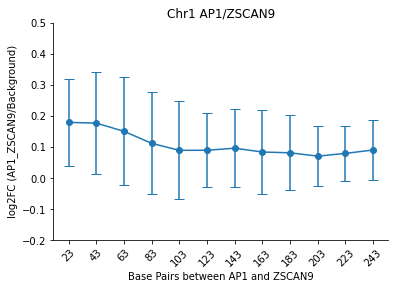

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def read_df(path):
    df = pd.read_csv(path, sep="\t", header=None)
    df.columns = ['location', 'ref_score', 'sequence', 'background_ref_score']
    df['fc'] = df['ref_score'] - df['background_ref_score']
    df['distance'] = np.tile(np.arange(23, 244, 20), len(df) // 12)
    df_fc = df.groupby('distance').agg(
        mean_fc=('fc', 'mean'),
        sd_fc=('fc', 'std')
    ).reset_index()
    
    return df_fc

path = '/hpc/home/rv103/revathy/BlueSTARR/test/data/K562/all_motifs/logfc/chr1-f-ap1-f-ZSCAN9-logfc.txt'
df_fc1 = read_df(path)

x = np.arange(23, 244, 20)
plt.errorbar(x, df_fc1['mean_fc'], yerr=df_fc1['sd_fc'], fmt='-o', capsize=5, lw=1.5)
plt.title("Chr1 AP1/ZSCAN9")
plt.ylim(-0.2, 0.5)
plt.xlabel("Base Pairs between AP1 and ZSCAN9")
plt.ylabel("log2FC (AP1_ZSCAN9/Background)")
plt.xticks(x, rotation=45)
plt.grid(False)
sns.despine()
plt.show()


In [4]:
%%writefile /hpc/home/rv103/revathy/BlueSTARR/test/scripts/plot_lineplots.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import argparse

def read_df(path):
    df = pd.read_csv(path, sep="\t", header=None)
    df.columns = ['location', 'ref_score', 'sequence', 'background_ref_score']
    df['fc'] = df['ref_score'] - df['background_ref_score']
    df['distance'] = np.tile(np.arange(23, 244, 20), len(df) // 12)
    df_fc = df.groupby('distance').agg(mean_fc=('fc', 'mean'), sd_fc=('fc', 'std')).reset_index()
    return df_fc

def main(directory, output_png):
    files = [f for f in os.listdir(directory) if f.endswith(".txt")]
    x = np.arange(23, 244, 20)
    
    plt.figure(figsize=(10, 8))
    for i, filename in enumerate(files):
        path = os.path.join(directory, filename)
        df_fc = read_df(path)
        plt.plot(x, df_fc['mean_fc'], label=f"File {i+1}: {filename}", lw=1.5)
        plt.text(x[-1] + 2, df_fc['mean_fc'].values[-1], f"{filename}", 
                 fontsize=8, va='center')
    
    plt.title("Mean log2FC for AP1 v/s all TF motifs in K562")
    plt.xlabel("Base Pairs between AP1 and Motif")
    plt.ylabel("Mean log2FC (Ap1_Motif/Background)")
    plt.xticks(x, rotation=45)
    plt.ylim(-0.5, 2)
    sns.despine()
    plt.tight_layout()
    plt.savefig(output_png)
    plt.close()
    
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="This script generates a single line plot with logFCs of all TFs.Here X-axis is position of motif2 and Y-axis is the logFC between motif1 & motif2.")
    parser.add_argument("directory", help='Path to the directory with the logFC files')
    parser.add_argument("output_png", help='Path to the output .PNG file')
    
    args = parser.parse_args()
    main(args.directory, args.output_png)

Overwriting /hpc/home/rv103/revathy/BlueSTARR/test/scripts/plot_lineplots.py


In [3]:
%%writefile /hpc/home/rv103/revathy/BlueSTARR/test/scripts/plot_boxplots.q
#!/bin/sh
#
#SBATCH --get-user-env
#SBATCH -J plot
#SBATCH --mail-user=rv103@duke.edu
#SBATCH --mail-type=END,FAIL
#SBATCH --gres=gpu:1
#SBATCH -p majoroslab-gpu,scavenger-gpu
#SBATCH --nice=100
#SBATCH --mem=102400
#SBATCH --cpus-per-task=1
#SBATCH -o /hpc/home/rv103/revathy/BlueSTARR/test/logs/K562_plot_boxplots.out
#SBATCH -e /hpc/home/rv103/revathy/BlueSTARR/test/logs/K562_plot_boxplots.err
#
python /hpc/home/rv103/revathy/BlueSTARR/test/scripts/plot_boxplots.py

Overwriting /hpc/home/rv103/revathy/BlueSTARR/test/scripts/plot_boxplots.q


In [10]:
%%writefile /hpc/home/rv103/revathy/BlueSTARR/test/scripts/plot_boxplots.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import argparse
from matplotlib.backends.backend_pdf import PdfPages

def read_df(path):
    # Read the file into a pandas DataFrame
    df = pd.read_csv(path, sep="\t", header=None)
    df.columns = ['location', 'ref_score', 'sequence', 'background_ref_score']
    df['fc'] = df['ref_score'] - df['background_ref_score']
    df['distance'] = np.tile(np.arange(23, 244, 20), len(df) // 12)
    df_fc = df.groupby('distance').agg(
        mean_fc=('fc', 'mean'),
        sd_fc=('fc', 'std')
    ).reset_index()
    
    return df_fc

def main(directory, output_pdf, plots_per_page=16):
    files = [f for f in os.listdir(directory) if f.endswith(".txt")]
    num_files = len(files)
    cols = 4  
    rows = plots_per_page // cols
    with PdfPages(output_pdf) as pdf:
        for page_start in range(0, num_files, plots_per_page):
            fig, axes = plt.subplots(rows, cols, figsize=(16, 16))  # Adjust figsize as needed
            axes = axes.flatten()
            for i in range(plots_per_page):
                file_idx = page_start + i
                if file_idx >= num_files:
                    axes[i].axis('off')
                else:
                    path = os.path.join(directory, files[file_idx])
                    df_fc = read_df(path)
                    x = np.arange(23, 244, 20)
#                     axes[i].plot(x, df_fc['mean_fc'], '-o', lw=1.5)
                    axes[i].errorbar(x, df_fc['mean_fc'], yerr=df_fc['sd_fc'], fmt='-o', capsize=5, lw=1.5)
                    axes[i].set_title(f"{files[file_idx]}", fontsize=8)
                    axes[i].set_ylim(-0.5, 1.5)
                    axes[i].set_xticks(x)
                    axes[i].tick_params(axis='x', rotation=45, labelsize=6)
                    axes[i].tick_params(axis='y', labelsize=6)
                    axes[i].grid(False)
                    
            plt.tight_layout()
            pdf.savefig(fig)
            plt.close(fig) 
            
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="This script boxplots of logFCs for each TF with the X-axis as the position of motif2 and Y-axis represents the logFC between motif1 & motif2.")
    parser.add_argument("directory", help='Path to the directory with the logFC files')
    parser.add_argument("output_pdf", help='Path to the output .pdf file')
    parser.add_argument("plots_per_page", help='Number of plots in a single page of the .pdf file', type=int)
    
    args = parser.parse_args()
    main(args.directory, args.output_pdf, args.plots_per_page)

Overwriting /hpc/home/rv103/revathy/BlueSTARR/test/scripts/plot_boxplots.py


In [11]:
%%writefile /hpc/home/rv103/revathy/BlueSTARR/test/scripts/plot_boxplots.q
#!/bin/sh
#
#SBATCH --get-user-env
#SBATCH -J boxplot
#SBATCH --mail-user=rv103@duke.edu
#SBATCH --mail-type=END,FAIL
#SBATCH --gres=gpu:1
#SBATCH -p majoroslab-gpu,scavenger-gpu
#SBATCH --nice=100
#SBATCH --mem=102400
#SBATCH --cpus-per-task=1
#SBATCH -o /hpc/home/rv103/revathy/BlueSTARR/test/logs/K562_plot_boxplots.out
#SBATCH -e /hpc/home/rv103/revathy/BlueSTARR/test/logs/K562_plot_boxplots.err
#
python /hpc/home/rv103/revathy/BlueSTARR/test/scripts/plot_boxplots.py \
/hpc/home/rv103/revathy/BlueSTARR/test/data/K562/all_motifs/logfc \
/hpc/home/rv103/revathy/BlueSTARR/test/data/K562/all_motifs/K562_AP1_all_motifs_boxplot.pdf 16

Overwriting /hpc/home/rv103/revathy/BlueSTARR/test/scripts/plot_boxplots.q


In [ ]:
if(len(sys.argv)!=4):
    exit(ProgramName.get()+" <directory> <output_pdf> <plots_per_page>\n")
(directory, output_pdf, plots_per_page)=sys.argv[1:]
main(directory, output_pdf, int(plots_per_page))